### Assignment 1: Registering Prokudin-Gorskii color separations of the Russian Empire
Due date: Monday, September 11, 11:59:59 PM

The goal of this assignment is to learn to work with images by taking the digitized Prokudin-Gorskii glass plate images and automatically producing a color image with as few visual artifacts as possible. In order to do this, you will need to extract the three color channel images, place them on top of each other, and align them so that they form a single RGB color image.

Some details are quite important. You should notice that it matters how you crop the images when you align them -- the separations may not overlap exactly. We have provided an RGB image to check your code on at this location. You should separate this image into three layers (R, G and B), then place each of those layers inside a slightly bigger, all white, layer, at different locations. Now register these three. You can tell whether you have the right answer in two ways: first, you shifted the layers with respect to one another, so you know the right shift to register them; second, if you look at the registered picture, the colors should be pure.

You will need to implement this assignment in Python, and you should familiarize yourself with libraries for scientific computing and image processing including NumPy and PIL.

In [18]:
# import data
import numpy as np
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt

In [3]:
# One such possibility is normalized cross-correlation (NCC), which is simply the dot product between the two images normalized to have zero mean and unit norm
def normalize(m):
    row_sums = m.sum(axis=1, keepdims=True)
    new_matrix = m / row_sums
    # print(new_matrix)
    return new_matrix
def ncc(img1, img2):
    img1_norm=normalize(img1)
    img2_norm=normalize(img2)
    p = np.sum(img1_norm*img2_norm)
    print(p)
    return p

def ssd(img1, img2):
    img1_norm=normalize(img1)
    img2_norm=normalize(img2)
    return np.sum((img1_norm-img2_norm)**2)

In [69]:
# ssd
import math
def displacement(img1, img2):
    out_i = 0
    out_j = 0
    min_val=math.inf
    max_val = math.inf
    win = 15
    # img1= img1.crop((0,0, img1.size[0], img1.size[1]))
    img1= img1.crop((win, win, img1.size[0]-win, img1.size[1]-win))
    img1_data = np.array(img1)

    for i in range(-win, win):
        for j in range(-win, win):
            # box = (i,j,img2.size[0]+i,img2.size[1]+j)
            box = (win+i,win+j,img2.size[0]-win+i,img2.size[1]-win+j)
            img2_trans = img2.crop(box)
            img2_data = np.array(img2_trans)
            val =ssd(img1_data, img2_data)
            # print(i, j, val)
            if val<min_val:
                min_val = val
                out_i = i
                out_j=j
    return out_i, out_j

def merge(im1, im2, x, y):
    w = im1.size[0] + 30
    h =im1.size[1] + 30
    im = Image.new('L', (w, h), (255))

    im.paste(im2, (15-x, 15-y))
    plt.figure()
    plt.title(str(x)+str(y))
    plt.imshow(im)

    return im


In [70]:
# test=Image.open("check.png")
# plt.figure()
# plt.title("test")
# plt.imshow(test)

# r, g, b = test.split()
# test_out = Image.merge('RGB',(r,g,b))
# plt.figure()
# plt.title("test_out")
# plt.imshow(test_out)
# ll.append(r)
# ll.append(g)
# ll.append(b)


In [71]:
# name = "00125v" 
# name = "00149v" 
# name = "00153v" # base2
# name = "00351v" 
# name = "00398v" 
name = "01112v" 

im=Image.open("data/{}.jpg".format(name)) 

# seperate image into three layers
ll=[]
size = int(im.size[1]/3)
for i in range(3):
    upper=i*size
    box = (0,upper,im.size[0],upper + size)
    tmp = im.crop(box)
    pad=35
    img = tmp.crop((pad,pad,tmp.size[0]-pad,tmp.size[1]-pad))
    ll.append(img)


1 0 0
2 -1 -5


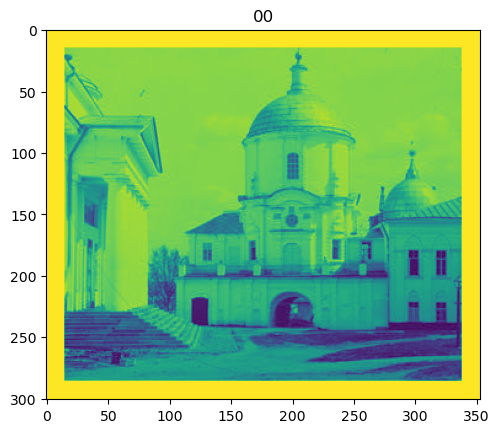

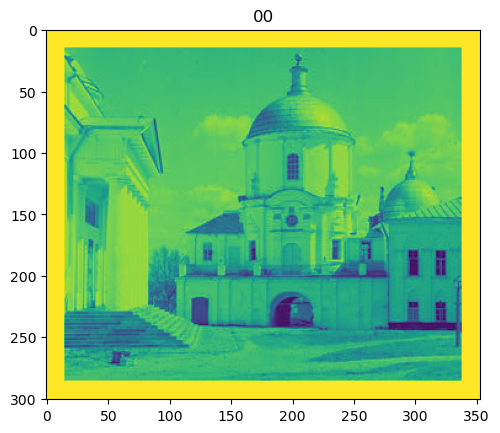

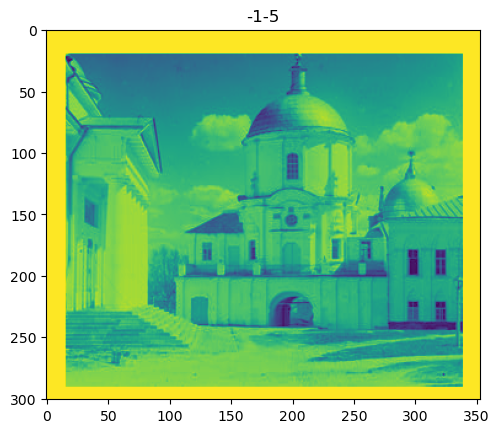

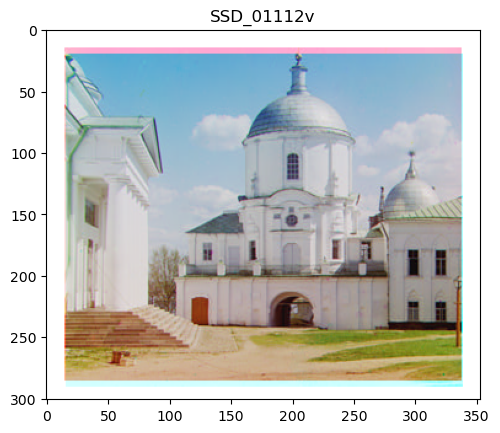

In [72]:

out_l=[]
base=0
out_l.append(merge(ll[base], ll[base], 0,0))

for i in [1,2]:
    x,y = displacement(ll[base], ll[i])
    print(i ,x,y)
    out_l.append(merge(ll[base], ll[i], x,y))


w = ll[base].size[0] + 30
h =ll[base].size[1] + 30
im_out = Image.merge('RGB', (out_l[2], out_l[1], out_l[0]))
white = Image.new('L', (w, h), (255))
# im_out = Image.merge('RGB', (out_l[2], white, white))
# im_out = Image.merge('RGB', (white,out_l[1], white))
# im_out = Image.merge('RGB', (white,white, out_l[0]))
# im_out.save("output/{}_{}.png".format(name, "SSD"),"PNG")
title = "{}_{}".format("SSD", name)
plt.figure()
plt.title(title)

plt.imshow(im_out)
plt.savefig("output/{}.jpg".format(title))

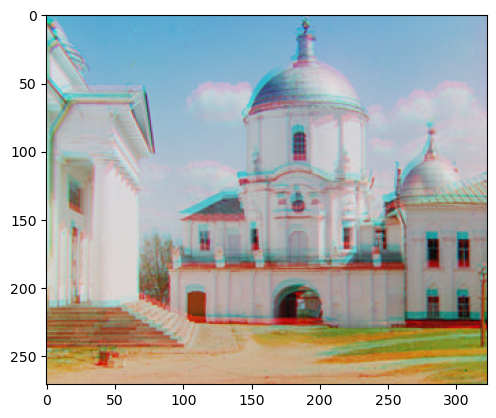

In [73]:

original = Image.merge('RGB', (ll[2],ll[1],ll[0]))
plt.figure()
plt.imshow(original)

#### Multiscale Alignment

For the high-resolution glass plate scans provided above, exhaustive search over all possible displacements will become prohibitively expensive. To deal with this case, implement a faster search procedure using an image pyramid. An image pyramid represents the image at multiple scales (usually scaled by a factor of 2) and the processing is done sequentially starting from the coarsest scale (smallest image) and going down the pyramid, updating your estimate as you go. It is very easy to implement by adding recursive calls to your original single-scale implementation.

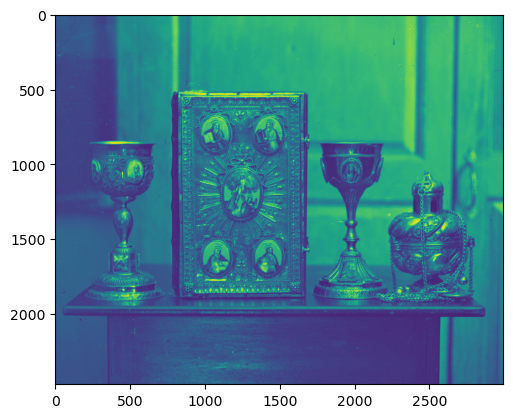

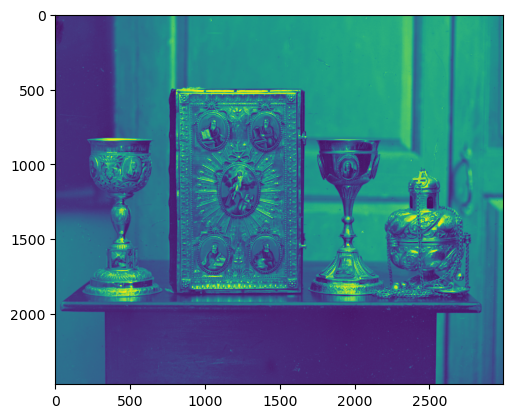

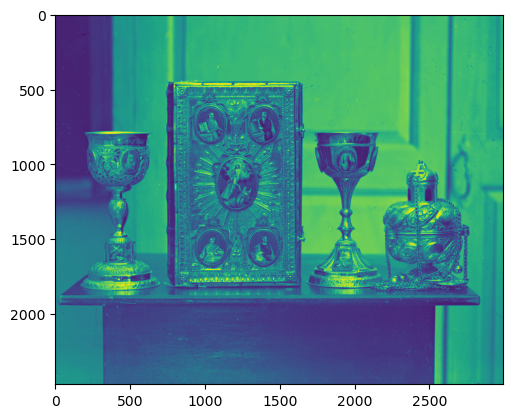

In [74]:
# load high quality images
name = "01047u" 

im=Image.open("data_hires/{}.tif".format(name)) 

# seperate image into three layers
imgs_high=[]
h = int(im.size[1]/3)
w = im.size[0]
pad=int(w*0.1)
for i in range(3):
    upper=i*h
    box = (0,upper, w,upper + h)
    tmp = im.crop(box)
    img = tmp.crop((pad,pad,tmp.size[0]-pad,tmp.size[1]-pad))
    imgs_high.append(img)

plt.figure()
plt.imshow(imgs_high[0])
plt.figure()
plt.imshow(imgs_high[1])
plt.figure()
plt.imshow(imgs_high[2])

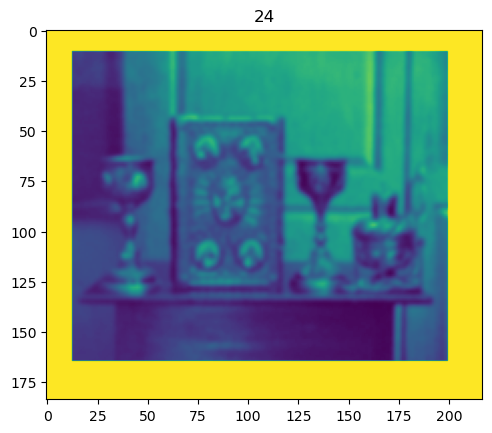

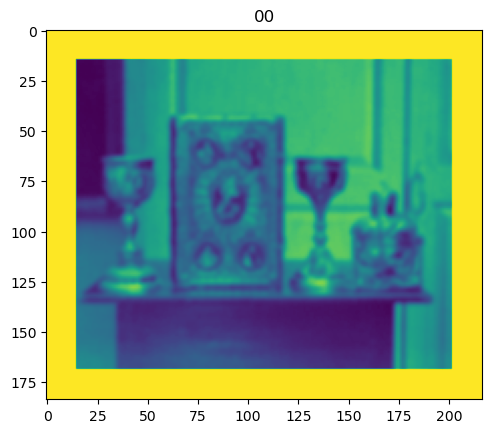

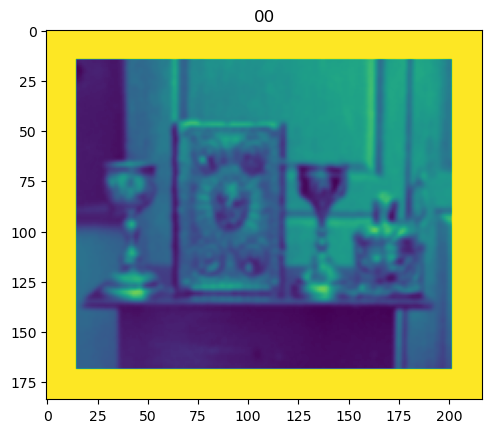

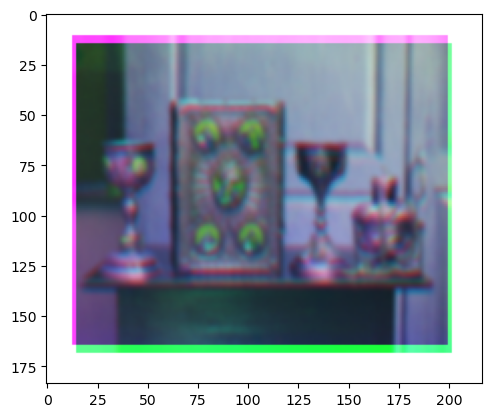

In [81]:
img = imgs_high[0]
n=5

def gaussian_pyramid(img, n=5):
    out = []
    img.mode = 'I'
    img = img.point(lambda i:i*(1./256)).convert('L')
    for i in range(n):
        img = img.filter(ImageFilter.GaussianBlur).resize((img.size[0]//2, img.size[1]//2))
        out.append(img)
    return out

img_pym_r = gaussian_pyramid(imgs_high[0])
img_pym_g = gaussian_pyramid(imgs_high[1])
img_pym_b = gaussian_pyramid(imgs_high[2])
# for i in range(5):
#     plt.figure()
#     plt.imshow(img_pym[i])

# find displacement
x,y = displacement(img_pym_b[n-1], img_pym_r[n-1])
img1 = img_pym_b[n-2]
img2 = img_pym_r[n-2]

def multi_scale(img1, img2):
    win= 15
    min_val=math.inf
    out_i, out_j=0,0
    img1= img1.crop((win, win, img1.size[0]-win, img1.size[1]-win))
    img1_data = np.array(img1)

    for i in [2*x, 2*x+1]:
        for j in [2*y, 2*y+1]:
            # box = (i,j,img2.size[0]+i,img2.size[1]+j)
            box = (win+i,win+j,img2.size[0]-win+i,img2.size[1]-win+j)
            img2_trans = img2.crop(box)
            img2_data = np.array(img2_trans)
            val =ssd(img1_data, img2_data)
            # print(i, j, val)
            if val<min_val:
                min_val = val
                out_i = i
                out_j = j
    return out_i, out_j


w = img1.size[0] + 30
h =img1.size[1] + 30
white = Image.new('L', (w, h), (255))


fx, fy = multi_scale(img1, img2)
im_out = merge(img1, img2, fx, fy)
im_out1 = merge(img1, img1, 0, 0)
im_out2 = merge(img1, img_pym_g[n-2], 0, 0)
im_fin = Image.merge('RGB', (im_out2,im_out,im_out1))

plt.figure()
plt.imshow(im_fin)
